Esse script foi feito adaptando as análises que já havia realizando antes com R, mas para Phyton, para aprender na prática a linguagem. O Script contém exemplo de análises estatísticas básicas, a partir de análise tabular, e teste de chi quadrado, Teste para diferença de médias, Correlação de Pearson e Regressão Linear

Principais mudanças do R para o Python pelo que eu pesquisei:

- tidyverse - pandas
- ggplot2 - matplotlib/seaborn
- CrossTable() - scipy.stats.chi2_contingency()
- t.test() - scipy.stats.ttest_ind()
- lm() - statsmodels.api.OLS()
- cor.test() - scipy.stats.pearsonr()

In [19]:
github_base = "https://raw.githubusercontent.com/diegoamrg4123/script_estatistica_aplicada_2023/main/"

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings("ignore")

In [21]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

In [22]:
def crosstab_chi2(var1, var2, var1_name="Var1", var2_name="Var2"):
    temp_df = pd.DataFrame({var1_name: var1, var2_name: var2})
    temp_df_clean = temp_df.dropna()
    if len(temp_df_clean) == 0:
        print(f"nenhuma observacao valida para {var1_name} vs {var2_name}")
        return None, None, None
    var1_clean = temp_df_clean[var1_name]
    var2_clean = temp_df_clean[var2_name]
    print(f"\n{'='*60}")
    print(f"teste chi-quadrado: {var1_name} vs {var2_name}")
    print(f"observacoes validas: {len(temp_df_clean)}")
    contingency_table = pd.crosstab(var1_clean, var2_clean, margins=True)
    print(f"\ntabela de contingencia")
    print(contingency_table)
    table_no_margins = pd.crosstab(var1_clean, var2_clean)
    chi2, p_value, dof, expected = chi2_contingency(table_no_margins)
    print(f"\nresultados:")
    print(f"chi-quadrado: {chi2:.4f}")
    print(f"graus de liberdade: {dof}")
    print(f"p-valor: {p_value:.6f}")
    print(f"valor critico (a=0.05): {stats.chi2.ppf(0.95, dof):.4f}")
    if p_value < 0.05:
        print("p valor e menor que 0,05, podemos rejeitar a hipotese nula de que qualquer relacao vem do acaso")
    else:
        print("p valor foi maior que 0,05")
    print(f"\ndistribuicao percentual")
    percent_table = pd.crosstab(var1_clean, var2_clean, normalize='index') * 100
    print(percent_table.round(1))
    return chi2, p_value, contingency_table

In [23]:
anes_url = github_base + "ANES2016small.csv"
print(f"carregando: {anes_url}")
try:
    anes_data = pd.read_csv(anes_url, na_values=['NA'])
    print(f"anes2016 carregado: {anes_data.shape[0]} linhas x {anes_data.shape[1]} colunas")
    print(f"\ncolunas:")
    for i, col in enumerate(anes_data.columns, 1):
        print(f"   {i:2d}. {col}")
    print(f"\nvalores ausentes por variavel:")
    for col in ['V2Trump', 'unionHH', 'female']:
        if col in anes_data.columns:
            missing = anes_data[col].isna().sum()
            valid = len(anes_data) - missing
            print(f"   {col}: {valid} validos, {missing} ausentes")
    anes_clean = anes_data[['V2Trump', 'unionHH', 'female']].dropna()
    print(f"\ndataset limpo: {len(anes_clean)} observacoes completas")
    if len(anes_clean) > 0:
        print(f"\n1- voto trump vs uniao no domicilioo")
        crosstab_chi2(anes_clean['V2Trump'], anes_clean['unionHH'],
                     "voto trump", "uniao no domicilio")
        print(f"\n2- voto trump vs genero")
        crosstab_chi2(anes_clean['V2Trump'], anes_clean['female'],
                     "voto trump", "genero")
    else:
        print("nenhuma observacao")
except Exception as e:
    print(f"nao conseguiu carregar os dados: {e}")


carregando: https://raw.githubusercontent.com/diegoamrg4123/script_estatistica_aplicada_2023/main/ANES2016small.csv
anes2016 carregado: 4271 linhas x 3 colunas

colunas:
    1. unionHH
    2. V2Trump
    3. female

valores ausentes por variavel:
   V2Trump: 2468 validos, 1803 ausentes
   unionHH: 4244 validos, 27 ausentes
   female: 4219 validos, 52 ausentes

dataset limpo: 2437 observacoes completas

1- voto trump vs uniao no domicilioo

teste chi-quadrado: voto trump vs uniao no domicilio
observacoes validas: 2437

tabela de contingencia
uniao no domicilio   0.0  1.0   All
voto trump                         
0.0                 1052  215  1267
1.0                 1014  156  1170
All                 2066  371  2437

resultados:
chi-quadrado: 5.9521
graus de liberdade: 1
p-valor: 0.014700
valor critico (a=0.05): 3.8415
p valor e menor que 0,05, podemos rejeitar a hipotese nula de que qualquer relacao vem do acaso

distribuicao percentual
uniao no domicilio   0.0   1.0
voto trump       

In [24]:
print(f"\n{'='*60}")
print("teste t para diferenca de medias")
corruption_url = github_base + "ti_corruption_perception_index.csv"
print(f"carregando: {corruption_url}")
try:
    corruption_data = pd.read_csv(corruption_url, sep=';', encoding='utf-8')
    print(f"corrupcao - carregando: {corruption_data.shape[0]} linhas x {corruption_data.shape[1]} colunas")
    print(f"\n5 primeiras linhas:")
    print(corruption_data.head())
    print(f"\ncolunas:")
    for i, col in enumerate(corruption_data.columns, 1):
        print(f"   {i:2d}. {col}")
except Exception as e:
    print(f"erro de carregamento de dados: {e}")



teste t para diferenca de medias
carregando: https://raw.githubusercontent.com/diegoamrg4123/script_estatistica_aplicada_2023/main/ti_corruption_perception_index.csv
corrupcao - carregando: 1952 linhas x 5 colunas

5 primeiras linhas:
        Entity Code  Year  Corruption Perceptions Index  \
0  Afghanistan  AFG  2012                             8   
1      Albania  ALB  2012                            33   
2      Algeria  DZA  2012                            34   
3       Angola  AGO  2012                            22   
4    Argentina  ARG  2012                            35   

   World regions according to OWID  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  

colunas:
    1. Entity
    2. Code
    3. Year
    4. Corruption Perceptions Index
    5. World regions according to OWID


In [25]:
year_col = None
for col in corruption_data.columns:
    if 'year' in col.lower():
        year_col = col
        break
if year_col:
    print(f"coluna ano achada: '{year_col}'")
    try:
        years_available = sorted([y for y in corruption_data[year_col].unique()
                                if isinstance(y, (int, float)) and not pd.isna(y)])
        print(f"anos disponiveis: {years_available}")
    except:
        print("problemas com a coluna ano")
        year_col = None
else:
    print("coluna ano nao encontrada")

corruption_col = None
for col in corruption_data.columns:
    if any(word in col.lower() for word in ['corruption', 'perception', 'index']):
        corruption_col = col
        break
if not corruption_col:
    print("coluna de corrupcao nao encontrada")
    print("colunas disponiveis:")
    for i, col in enumerate(corruption_data.columns, 1):
        print(f"   {i:2d}. '{col}'")
    raise Exception("coluna indice nao encontrada")
else:
    print(f"coluna de indice: '{corruption_col}'")


coluna ano achada: 'Year'
anos disponiveis: []
coluna de indice: 'Corruption Perceptions Index'


In [26]:
# tentativa de identificar a coluna de paises
entity_cols = [col for col in corruption_data.columns if any(word in col.lower() for word in ['entity', 'country', 'name'])]
if entity_cols:
    entity_col = entity_cols[0]
    print(f"coluna de paises identificada: '{entity_col}'")
else:
    # usar a primeira coluna como fallback
    entity_col = corruption_data.columns[0]
    print(f"coluna de paises assumida como: '{entity_col}'")

paises_americas = ['United States', 'Canada', 'Mexico', 'Brazil', 'Chile', 'Argentina']
#para selecionar os dados de 2022 nas americas
if year_col:
    print(f"filtrando por ano 2022 nas americas")
    americas_data = corruption_data[
        (corruption_data[year_col] == 2022) &
        (corruption_data[entity_col].isin(paises_americas))
    ].copy()
else:
    print(f"filtrando por paises nas americas (sem filtro de ano)")
    americas_data = corruption_data[
        corruption_data[entity_col].isin(paises_americas)
    ].copy()

print(f"\ndados filtrados: {len(americas_data)} paises")


coluna de paises identificada: 'Entity'
filtrando por ano 2022 nas americas

dados filtrados: 6 paises


In [27]:
if len(americas_data) > 0:
    def classificar_regiao(pais):
        if pais in ['United States', 'Canada', 'Mexico']:
            return 'america do norte'
        else:
            return 'america do sul'
    americas_data['regiao'] = americas_data[entity_col].apply(classificar_regiao)
    americas_data = americas_data.rename(columns={corruption_col: 'corruption_index'})
    # limpar dados ausentes
    americas_data = americas_data.dropna(subset=['corruption_index'])
    print(f"\ndados finais:")
    print(americas_data[[entity_col, 'corruption_index', 'regiao']].to_string(index=False))
else:
    print("erro")


dados finais:
       Entity  corruption_index           regiao
    Argentina                38   america do sul
       Brazil                38   america do sul
       Canada                74 america do norte
        Chile                67   america do sul
       Mexico                31 america do norte
United States                69 america do norte


In [28]:
if len(americas_data) > 0:
    print(f"\nestatisticas por regiao:")
    stats_desc = americas_data.groupby('regiao').agg({
        'corruption_index': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    stats_desc.columns = ['n', 'media', 'desvio', 'minimo', 'maximo']
    print(stats_desc)


estatisticas por regiao:
                  n  media  desvio  minimo  maximo
regiao                                            
america do norte  3  58.00   23.52      31      74
america do sul    3  47.67   16.74      38      67


In [29]:
if len(americas_data) > 0:
    north_data = americas_data[americas_data['regiao'] == 'america do norte']['corruption_index']
    south_data = americas_data[americas_data['regiao'] == 'america do sul']['corruption_index']
    if len(north_data) > 0 and len(south_data) > 0:
        t_stat, p_value = ttest_ind(north_data, south_data, equal_var=True)
        print(f"\nteste t para diferenca de medias")
        print(f"america do norte: n={len(north_data)}, media={north_data.mean():.2f}")
        print(f"america do sul: n={len(south_data)}, media={south_data.mean():.2f}")
        print(f"teste t: {t_stat:.4f}")
        print(f"p valor: {p_value:.6f}")
        if p_value < 0.05:
            print("p valor e menor que 0,05, ha diferenca estatisticamente relevante")
        else:
            print("p valor nao satisfaz a condicao, nao podemos rejeitar a hipotese nula")
    else:
        print("erro")
else:
    print("erro")



teste t para diferenca de medias
america do norte: n=3, media=58.00
america do sul: n=3, media=47.67
teste t: 0.6200
p valor: 0.568832
p valor nao satisfaz a condicao, nao podemos rejeitar a hipotese nula



boxplot - comparacao visual


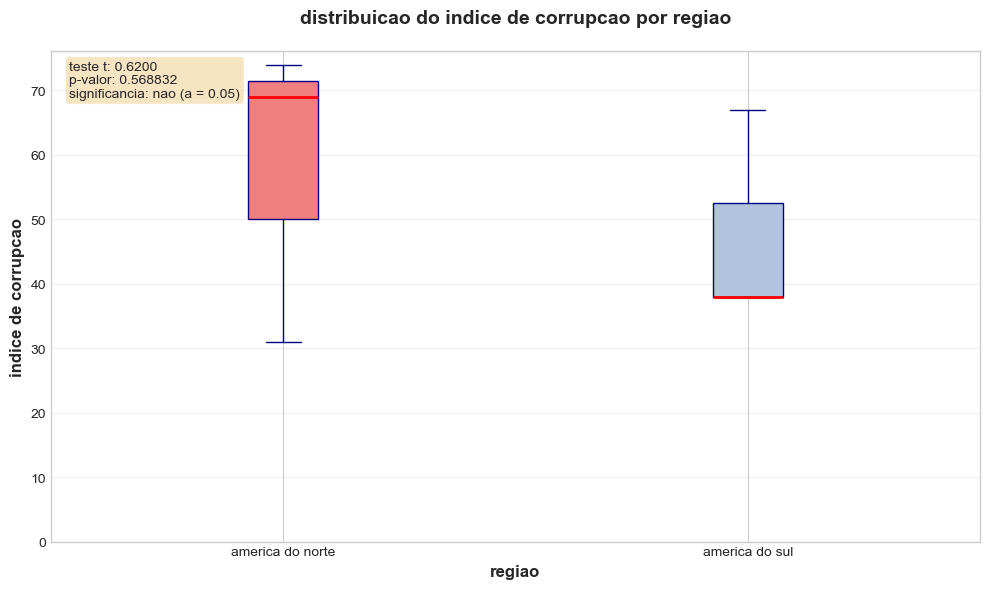


estatisticas descritivas:
----------------------------------------
america do norte:
  media: 58.00
  mediana: 69.00
  desvio padrao: 23.52
  min: 31.00 | max: 74.00

america do sul:
  media: 47.67
  mediana: 38.00
  desvio padrao: 16.74
  min: 38.00 | max: 67.00


In [30]:
print(f"\n{'='*60}")
print("boxplot - comparacao visual")
print("="*60)
plt.figure(figsize=(10, 6))
dados_boxplot = [north_data, south_data]
labels = ['america do norte', 'america do sul']
box_plot = plt.boxplot(dados_boxplot,
                      labels=labels,
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='navy'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='navy'),
                      capprops=dict(color='navy'),
                      flierprops=dict(marker='o', color='red', alpha=0.7))
colors = ['lightcoral', 'lightsteelblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
plt.title('distribuicao do indice de corrupcao por regiao',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('indice de corrupcao', fontsize=12, fontweight='bold')
plt.xlabel('regiao', fontsize=12, fontweight='bold')
info_text = f"""teste t: {t_stat:.4f}
p-valor: {p_value:.6f}
significancia: {'sim' if p_value < 0.05 else 'nao'} (a = 0.05)"""
plt.text(0.02, 0.98, info_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

print(f"\nestatisticas descritivas:")
print("-" * 40)
print(f"america do norte:")
print(f"  media: {north_data.mean():.2f}")
print(f"  mediana: {north_data.median():.2f}")
print(f"  desvio padrao: {north_data.std():.2f}")
print(f"  min: {north_data.min():.2f} | max: {north_data.max():.2f}")
print(f"\namerica do sul:")
print(f"  media: {south_data.mean():.2f}")
print(f"  mediana: {south_data.median():.2f}")
print(f"  desvio padrao: {south_data.std():.2f}")
print(f"  min: {south_data.min():.2f} | max: {south_data.max():.2f}")


In [34]:
print(f"\n{'='*60}")
print("correlacao - democracia e empoderamento feminino")
print("="*60)
democracy_url = github_base + "liberal_democracy_index.csv"
women_url = github_base + "women_political_empowerment_index.csv"
try:
    print(f"carregando democracia: {democracy_url}")
    democracy_data = pd.read_csv(democracy_url, sep=';', encoding='utf-8')
    print(f"democracia: {democracy_data.shape[0]} linhas x {democracy_data.shape[1]} colunas")
    print(f"carregando empoderamento: {women_url}")
    women_data = pd.read_csv(women_url, sep=';', encoding='utf-8')
    print(f"empoderamento: {women_data.shape[0]} linhas x {women_data.shape[1]} colunas")
    print(f"\ncolunas democracia:")
    for i, col in enumerate(democracy_data.columns, 1):
        print(f"   {i:2d}. {col}")
    print(f"\ncolunas empoderamento:")
    for i, col in enumerate(women_data.columns, 1):
        print(f"   {i:2d}. {col}")
    democracy_year_cols = [col for col in democracy_data.columns if 'year' in col.lower()]
    women_year_cols = [col for col in women_data.columns if 'year' in col.lower()]
    democracy_index_cols = [col for col in democracy_data.columns if 'democracy' in col.lower()]
    women_index_cols = [col for col in women_data.columns
                       if any(word in col.lower() for word in ['women', 'empowerment', 'political'])]
    if democracy_index_cols and women_index_cols:
        democracy_col = democracy_index_cols[0]
        women_col = women_index_cols[0]
        print(f"\nindice democracia: '{democracy_col}'")
        print(f"indice empoderamento: '{women_col}'")
        # tentativa de identificar colunas de paises
        democracy_entity_cols = [col for col in democracy_data.columns if any(word in col.lower() for word in ['entity', 'country', 'name'])]
        women_entity_cols = [col for col in women_data.columns if any(word in col.lower() for word in ['entity', 'country', 'name'])]
        democracy_entity_col = democracy_entity_cols[0] if democracy_entity_cols else democracy_data.columns[0]
        women_entity_col = women_entity_cols[0] if women_entity_cols else women_data.columns[0]
        print(f"coluna de paises em democracia: '{democracy_entity_col}'")
        print(f"coluna de paises em empoderamento: '{women_entity_col}'")

        # identificar colunas de codigo
        democracy_code_cols = [col for col in democracy_data.columns if 'code' in col.lower()]
        women_code_cols = [col for col in women_data.columns if 'code' in col.lower()]
        democracy_code_col = democracy_code_cols[0] if democracy_code_cols else None
        women_code_col = women_code_cols[0] if women_code_cols else None

        if democracy_year_cols and women_year_cols:
            democracy_year_col = democracy_year_cols[0]
            women_year_col = women_year_cols[0]
            print(f"filtrando dados para 2022")
            democracy_2022 = democracy_data[democracy_data[democracy_year_col] == 2022]
            women_2022 = women_data[women_data[women_year_col] == 2022]
            print(f"democracia 2022: {len(democracy_2022)} paises")
            print(f"empoderamento 2022: {len(women_2022)} paises")
        else:
            print("colunas de ano nao encontradas, usando todos os dados")
            democracy_2022 = democracy_data.copy()
            women_2022 = women_data.copy()

        # selecionar colunas necessarias
        if democracy_code_col and women_code_col:
            democracy_subset = democracy_2022[[democracy_entity_col, democracy_code_col, democracy_col]].rename(
                columns={democracy_col: 'democracy_index', democracy_entity_col: 'entity', democracy_code_col: 'code'}
            ).dropna()
            women_subset = women_2022[[women_entity_col, women_code_col, women_col]].rename(
                columns={women_col: 'women_index', women_entity_col: 'entity', women_code_col: 'code'}
            ).dropna()
        else:
            democracy_subset = democracy_2022[[democracy_entity_col, democracy_col]].rename(
                columns={democracy_col: 'democracy_index', democracy_entity_col: 'entity'}
            ).dropna()
            women_subset = women_2022[[women_entity_col, women_col]].rename(
                columns={women_col: 'women_index', women_entity_col: 'entity'}
            ).dropna()

        # tentar fazer o merge
        if democracy_code_col and women_code_col:
            combined_data = pd.merge(democracy_subset, women_subset, on=['entity', 'code'], how='inner')
        else:
            combined_data = pd.merge(democracy_subset, women_subset, on=['entity'], how='inner')

        combined_data = combined_data.dropna()
        print(f"\ndados combinados: {len(combined_data)} paises")
        if len(combined_data) > 10:
            print(f"\namostra dos dados:")
            print(combined_data.head(10)[['entity', 'democracy_index', 'women_index']].round(3).to_string(index=False))
            print("dados prontos")
        else:
            print("erro de dados insuficientes")
    else:
        print("erro - colunas de indices nao encontradas")
except Exception as e:
    print(f"erro para carregar dados: {e}")


correlacao - democracia e empoderamento feminino
carregando democracia: https://raw.githubusercontent.com/diegoamrg4123/script_estatistica_aplicada_2023/main/liberal_democracy_index.csv
democracia: 32267 linhas x 5 colunas
carregando empoderamento: https://raw.githubusercontent.com/diegoamrg4123/script_estatistica_aplicada_2023/main/women_political_empowerment_index.csv
erro para carregar dados: HTTP Error 429: Too Many Requests


In [35]:
r_corr, p_corr = pearsonr(combined_data['democracy_index'], combined_data['women_index'])
print(f"\nanalise de correlacao de pearson:")
print(f"correlacao de pearson (r): {r_corr:.4f}")
print(f"p-valor: {p_corr:.6f}")
print(f"r2 (variancia explicada): {r_corr**2:.4f} ({r_corr**2:.1%})")
if abs(r_corr) < 0.3:
    forca = "fraca"
elif abs(r_corr) < 0.7:
    forca = "moderada"
else:
    forca = "forte"
direcao = "positiva" if r_corr > 0 else "negativa"
print(f"correlacao {forca} e {direcao}")
if p_corr < 0.001:
    print("correlacao altamente significativa (p < 0.001)")
elif p_corr < 0.05:
    print("correlacao significativa (p < 0.05)")
else:
    print("correlacao nao significativa")



analise de correlacao de pearson:
correlacao de pearson (r): 0.7787
p-valor: 0.000000
r2 (variancia explicada): 0.6064 (60.6%)
correlacao forte e positiva
correlacao altamente significativa (p < 0.001)


In [36]:
print(f"\n{'='*60}")
print("regressao linear")
print("="*60)
X = combined_data['democracy_index']
y = combined_data['women_index']
X_const = sm.add_constant(X)
modelo = sm.OLS(y, X_const).fit()
print("resultados do modelo:")
print(f"r2: {modelo.rsquared:.4f} ({modelo.rsquared:.1%})")
print(f"r2 ajustado: {modelo.rsquared_adj:.4f}")
print(f"p-valor do modelo: {modelo.f_pvalue:.2e}")
intercepto = modelo.params[0]
coef_democracia = modelo.params[1]
print(f"\ncoeficientes:")
print(f"intercepto: {intercepto:.4f}")
print(f"democracia: {coef_democracia:.4f}")
print(f"para cada +1 na democracia, empoderamento aumenta {coef_democracia:.4f}")
if modelo.f_pvalue < 0.05:
    print("relacao estatisticamente significante")
else:
    print("p valor nao e menor que 0,05")



regressao linear
resultados do modelo:
r2: 0.6064 (60.6%)
r2 ajustado: 0.6042
p-valor do modelo: 1.77e-37

coeficientes:
intercepto: 0.5052
democracia: 0.5641
para cada +1 na democracia, empoderamento aumenta 0.5641
relacao estatisticamente significante


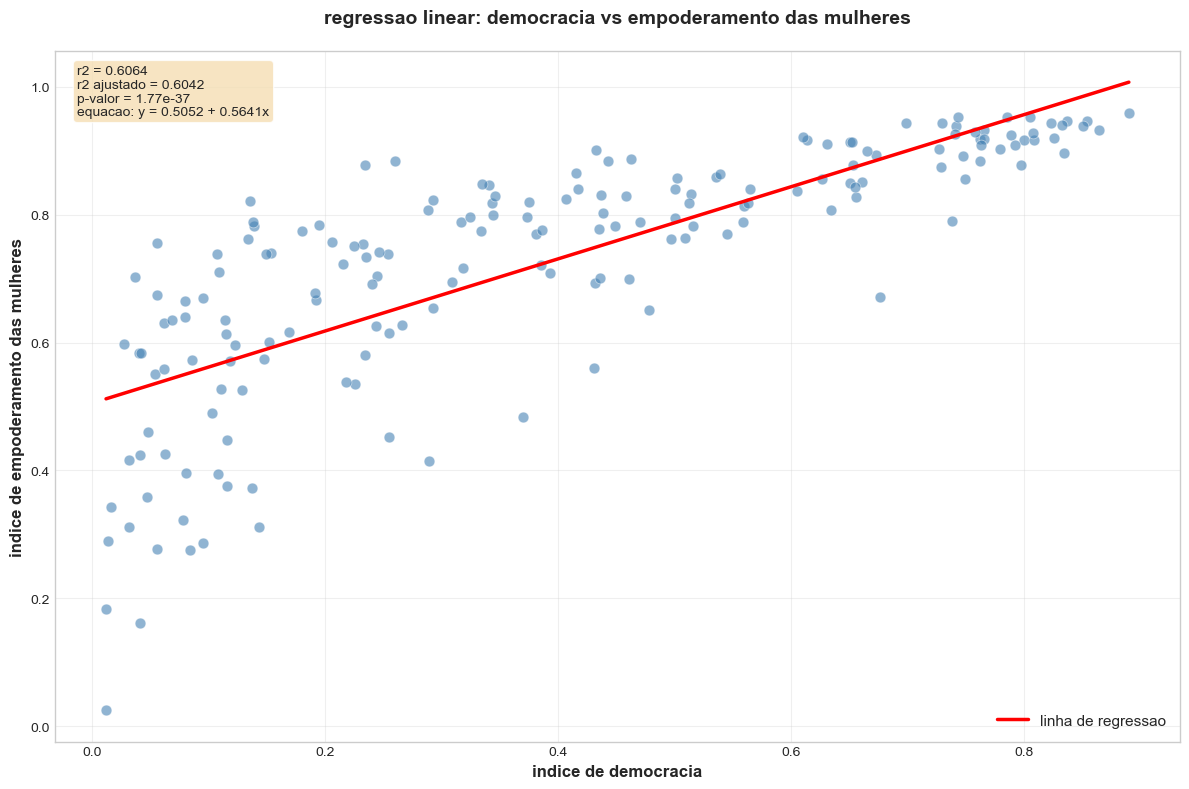

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(X, y, alpha=0.6, color='steelblue', s=60, edgecolor='white', linewidth=0.5)
x_linha = np.linspace(X.min(), X.max(), 100)
y_linha = intercepto + coef_democracia * x_linha
plt.plot(x_linha, y_linha, color='red', linewidth=2.5, label=f'linha de regressao')
plt.xlabel('indice de democracia', fontsize=12, fontweight='bold')
plt.ylabel('indice de empoderamento das mulheres', fontsize=12, fontweight='bold')
plt.title('regressao linear: democracia vs empoderamento das mulheres',
          fontsize=14, fontweight='bold', pad=20)
texto_stats = f"""r2 = {modelo.rsquared:.4f}
r2 ajustado = {modelo.rsquared_adj:.4f}
p-valor = {modelo.f_pvalue:.2e}
equacao: y = {intercepto:.4f} + {coef_democracia:.4f}x"""
plt.text(0.02, 0.98, texto_stats,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()